In [3]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
import joblib

In [5]:
# Paths & load data (prefers project/data/GermanCredit.csv)
PROJECT_ROOT = Path('.')
DATA_PATH = PROJECT_ROOT / 'data' / 'GermanCredit.csv'
FALLBACK = Path('/mnt/data/GermanCredit.csv')


if DATA_PATH.exists():
    csv_path = DATA_PATH
elif FALLBACK.exists():
    csv_path = FALLBACK
else:
    raise FileNotFoundError(f"Dataset not found. Expected at {DATA_PATH} or {FALLBACK}")


print('Loading dataset from:', csv_path)
df = pd.read_csv(csv_path)

Loading dataset from: data\GermanCredit.csv


In [6]:
# Quick EDA
print('Shape:', df.shape)
print('\nColumns:', list(df.columns))
display(df.head())


# target detection
POSSIBLE_TARGETS = ['credit_risk','Creditability','creditability','Risk','default']
for t in POSSIBLE_TARGETS:
    if t in df.columns:
        TARGET = t
        break
else:
    TARGET = df.columns[-1]


print('\nUsing target:', TARGET)
print(df[TARGET].value_counts(dropna=False))

Shape: (1000, 21)

Columns: ['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'credit_risk']


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee/official,1,no,yes,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,no,yes,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0



Using target: credit_risk
credit_risk
1    700
0    300
Name: count, dtype: int64


In [7]:
# Clean basic issues and convert target to numeric if needed
# Simple mappings
if df[TARGET].dtype == object:
    df[TARGET] = df[TARGET].replace({'good':0,'bad':1,'yes':1,'no':0})
try:
    df[TARGET] = pd.to_numeric(df[TARGET])
except Exception:
    pass

In [8]:
# Preprocessing helpers
num_cols = df.select_dtypes(include=['number']).columns.drop(TARGET).tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()


print('Numeric cols:', num_cols)
print('Categorical cols (sample):', cat_cols[:10])


# build preprocessor
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


preprocessor = ColumnTransformer([
('num', StandardScaler(), num_cols),
('cat', Pipeline([('ohe', ohe)]), cat_cols)
], remainder='drop')

Numeric cols: ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']
Categorical cols (sample): ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing']


In [9]:
# Train/test split and baseline logistic regression
X = df.drop(columns=[TARGET])
y = df[TARGET]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


logreg = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
logreg.fit(X_train, y_train)


# predictions & metrics
preds = logreg.predict(X_test)
probs = logreg.predict_proba(X_test)[:,1]
print('\nLogistic Regression Classification Report:')
print(classification_report(y_test, preds))
print('ROC AUC:', roc_auc_score(y_test, probs))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.45      0.48        60
           1       0.78      0.81      0.79       140

    accuracy                           0.70       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.70      0.70      0.70       200

ROC AUC: 0.7594047619047619


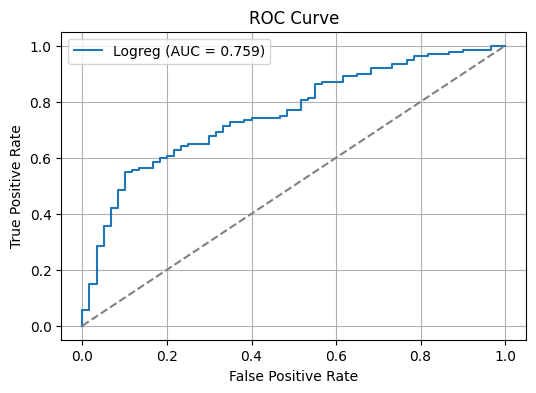

In [10]:
# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Logreg (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Train an XGBoost model (if installed) and compare
try:
    from xgboost import XGBClassifier
    xgb = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])
    xgb.fit(X_train, y_train)
    x_preds = xgb.predict(X_test)
    x_probs = xgb.predict_proba(X_test)[:,1]
    print('\nXGBoost Classification Report:')
    print(classification_report(y_test, x_preds))
    print('ROC AUC (XGB):', roc_auc_score(y_test, x_probs))
except Exception as e:
    print('XGBoost not available or failed to run:', e)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        60
           1       0.78      0.85      0.82       140

    accuracy                           0.73       200
   macro avg       0.67      0.65      0.66       200
weighted avg       0.72      0.73      0.72       200

ROC AUC (XGB): 0.7451190476190476


c:\Users\sowjanya adapa\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:38:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
# Save best model (choose by AUC)
models_info = {'logreg': (logreg, roc_auc_score(y_test, probs))}
try:
    if 'xgb' in locals():
        models_info['xgb'] = (xgb, roc_auc_score(y_test, x_probs))
except Exception:
    pass


best_name = max(models_info.items(), key=lambda kv: kv[1][1])[0]
best_model = models_info[best_name][0]
print('\nBest model chosen:', best_name)


Path('models').mkdir(exist_ok=True)
joblib.dump(best_model, Path('models') / 'best_model.pkl')
print('Saved model to models/best_model.pkl')


Best model chosen: logreg
Saved model to models/best_model.pkl


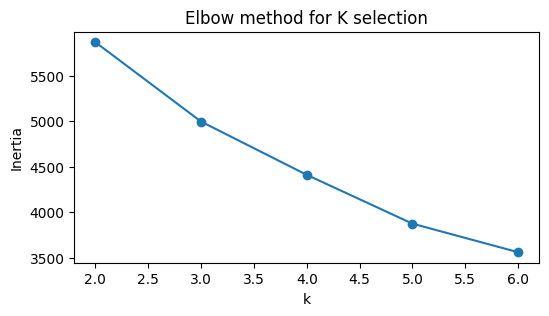

In [13]:
# Basic segmentation with KMeans (on numeric features)
# We'll use scaled numeric features only for clustering
from sklearn.preprocessing import StandardScaler
num_df = df[num_cols].fillna(df[num_cols].median())
sc = StandardScaler()
num_scaled = sc.fit_transform(num_df)


# choose k (simple elbow method quick check)
inertia = []
K = range(2,7)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(num_scaled)
    inertia.append(km.inertia_)


plt.figure(figsize=(6,3))
plt.plot(K, inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method for K selection')
plt.show()

In [14]:
# choose k=3 by default
k = 3
km = KMeans(n_clusters=k, random_state=42)
clusters = km.fit_predict(num_scaled)
df['cluster'] = clusters


# cluster profiles
print('\nCluster counts:')
print(df['cluster'].value_counts())


cluster_profile = df.groupby('cluster')[num_cols].mean()
display(cluster_profile)


Cluster counts:
cluster
1    686
0    173
2    141
Name: count, dtype: int64


,duration,amount,installment_rate,present_residence,age,number_credits,people_liable
cluster,,,,,,,
0,38.878613,7936.895954,2.606936,2.780347,35.479769,1.433526,1.080925
1,16.951895,2187.798834,3.099125,2.841108,34.896501,1.368805,1.000000
2,18.070922,2818.049645,2.808511,2.943262,38.787234,1.560284,2.000000


In [17]:
# Create folder if it does not exist
Path("reports").mkdir(exist_ok=True)

# Save clustered dataset
df.to_csv(Path("reports") / "germancredit_with_clusters.csv", index=False)

print("Saved clustered dataset to reports/germancredit_with_clusters.csv")

Saved clustered dataset to reports/germancredit_with_clusters.csv
